In [295]:
import sys
import os
import pandas as pd
import yfinance as yf
import warnings

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt

from yahooquery import Ticker
import requests

import datetime

warnings.filterwarnings("ignore", category=FutureWarning)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [41]:
import gspread

# gc = gspread.service_account(filename='stocksflags-ec5c40f2f2ee.json')
gc = gspread.service_account(filename='rational-diode-456114-m0-79243525427e.json')


ginzu_spreadsheet_link = 'https://docs.google.com/spreadsheets/d/1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks/edit?usp=sharing'
pricer = gc.open_by_url(ginzu_spreadsheet_link)
input_worksheet = pricer.get_worksheet(0)
valuation_worksheet = pricer.get_worksheet(1)

In [42]:
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SERVICE_ACCOUNT_FILE = 'rational-diode-456114-m0-79243525427e.json'

spreadsheet_id = '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks'
sheet_name = 'Input sheet'

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
service = build('sheets', 'v4', credentials=creds)

2025-04-24 20:46:05,298 - googleapiclient.discovery_cache - INFO - file_cache is only supported with oauth2client<4.0.0


In [43]:
def get_dropdown_options(spreadsheet_id: str, sheet_name: str, cell: str) -> list:
    """
    Given a spreadsheet ID, sheet name, and cell (e.g., 'B7'),
    returns the dropdown options (either hardcoded or from a range).
    """
    range_name = f"'{sheet_name}'!{cell}"
    
    try:
        response = service.spreadsheets().get(
            spreadsheetId=spreadsheet_id,
            ranges=[range_name],
            includeGridData=True,
            fields='sheets.data.rowData.values.dataValidation'
        ).execute()

        validation = response['sheets'][0]['data'][0]['rowData'][0]['values'][0]['dataValidation']
        condition = validation['condition']
        dropdown_values = [v['userEnteredValue'] for v in condition.get('values', [])]

        dropdown_ref = dropdown_values[0]
        if dropdown_ref.startswith("="):
            raw_ref = dropdown_ref.lstrip("=").replace("'", "")
            ref_sheet, ref_range = raw_ref.split("!")

            country_resp = service.spreadsheets().values().get(
                spreadsheetId=spreadsheet_id,
                range=f"{ref_sheet}!{ref_range}"
            ).execute()

            return [row[0].strip() for row in country_resp.get("values", []) if row and row[0].strip()]
        else:
            return dropdown_values

    except (KeyError, IndexError):
        print(f"No dropdown (data validation) found at {sheet_name}!{cell}.")
        return []


In [151]:
def get_latest_10k_financials(symbol):
    ticker = Ticker(symbol)

    # Annual financials
    income = ticker.income_statement(frequency='a')
    balance = ticker.balance_sheet(frequency='a')

    # Reset index to get access to 'asOfDate' and other columns
    income = income.reset_index()
    balance = balance.reset_index()

    # Filter for the most recent 12M data
    income_12m = income[income['periodType'] == '12M']
    balance_12m = balance[balance['periodType'] == '12M']

    # Sort and get the most recent fiscal year
    latest_income = income_12m.sort_values('asOfDate').iloc[-1]
    latest_balance = balance_12m.sort_values('asOfDate').iloc[-1]

    # Get the previous fiscal year for comparison
    prev_income = income_12m.sort_values('asOfDate').iloc[-2] if len(income_12m) > 1 else None
    prev_balance = balance_12m.sort_values('asOfDate').iloc[-2] if len(balance_12m) > 1 else None

    # Calculate years since last 10-K
    if prev_income is not None:
        years_since_last_10k = (latest_income["asOfDate"] - prev_income["asOfDate"]).days / 365
    else:
        years_since_last_10k = None

    # Extract Book Value of Equity (OrdinarySharesNumber)
    latest_book_value_of_equity = latest_balance.get("OrdinarySharesNumber")
    prev_book_value_of_equity = prev_balance.get("OrdinarySharesNumber") if prev_balance is not None else None

    # Extract Minority Interests
    latest_minority_interests = latest_balance.get("TotalEquityGrossMinorityInterest") or latest_balance.get("TotalLiabilitiesNetMinorityInterest") or latest_balance.get("TotalNonCurrentLiabilitiesNetMinorityInterest")
    prev_minority_interests = prev_balance.get("TotalEquityGrossMinorityInterest") or prev_balance.get("TotalLiabilitiesNetMinorityInterest") or prev_balance.get("TotalNonCurrentLiabilitiesNetMinorityInterest") if prev_balance is not None else None

    # R&D and operating lease flags
    r_and_d_expenses = "R&D" in latest_income.index and latest_income["R&D"] > 0
    operating_lease_commitments = "OperatingLease" in latest_balance.index

    # Shares outstanding and stock price
    shares_outstanding = latest_balance.get("OrdinarySharesNumber")
    current_stock_price = ticker.history(period='1d')['close'].iloc[-1] if not ticker.history(period='1d').empty else None

    # Use TaxRateForCalc for effective tax rate
    effective_tax_rate = latest_income.get("TaxRateForCalcs")

    # Use static U.S. corporate rate as marginal tax rate
    marginal_tax_rate = 0.21

    # Get 10-year treasury rate from Yahoo Finance (^TNX gives 10Y yield * 100)

    risk_free_rate = 0.0427

    return {
        "B11": latest_income.get("TotalRevenue"),
        "C11": prev_income.get("TotalRevenue") if prev_income is not None else None,
        "D11": years_since_last_10k,
        "B12": latest_income.get("EBIT"),
        "C12": prev_income.get("EBIT") if prev_income is not None else None,
        "B13": latest_income.get("InterestExpense"),
        "C13": prev_income.get("InterestExpense") if prev_income is not None else None,
        "B14": latest_book_value_of_equity,
        "C14": prev_book_value_of_equity,
        "B15": latest_balance.get("TotalDebt"),
        "C15": prev_balance.get("TotalDebt") if prev_balance is not None else None,
        "B16": "Yes" if r_and_d_expenses else "No",
        "B17": "Yes" if operating_lease_commitments else "No",
        "B18": latest_balance.get("CashAndCashEquivalents"),
        "C18": prev_balance.get("CashAndCashEquivalents") if prev_balance is not None else None,
        "B19": latest_balance.get("InvestmentsAndAdvances"),
        "C19": prev_balance.get("InvestmentsAndAdvances") if prev_balance is not None else None,
        "B20": latest_minority_interests,
        "C20": prev_minority_interests,
        "B21": shares_outstanding,
        "B22": current_stock_price,
        "B23": effective_tax_rate,
        "B24": marginal_tax_rate,
        "B33": risk_free_rate
    }

In [113]:
# List all columns in the balance sheet data
balance_12m.columns

Index(['symbol', 'asOfDate', 'periodType', 'currencyCode', 'AccountsPayable',
       'AccountsReceivable', 'AccumulatedDepreciation',
       'AvailableForSaleSecurities', 'CapitalLeaseObligations', 'CapitalStock',
       'CashAndCashEquivalents', 'CashCashEquivalentsAndShortTermInvestments',
       'CashEquivalents', 'CashFinancial', 'CommercialPaper', 'CommonStock',
       'CommonStockEquity', 'CurrentAssets', 'CurrentCapitalLeaseObligation',
       'CurrentDebt', 'CurrentDebtAndCapitalLeaseObligation',
       'CurrentDeferredLiabilities', 'CurrentDeferredRevenue',
       'CurrentLiabilities', 'GainsLossesNotAffectingRetainedEarnings',
       'GrossPPE', 'IncomeTaxPayable', 'Inventory', 'InvestedCapital',
       'InvestmentinFinancialAssets', 'InvestmentsAndAdvances',
       'LandAndImprovements', 'Leases', 'LongTermCapitalLeaseObligation',
       'LongTermDebt', 'LongTermDebtAndCapitalLeaseObligation',
       'MachineryFurnitureEquipment', 'NetDebt', 'NetPPE', 'NetTangibleAssets',
  

In [115]:
income_statement_df = pd.DataFrame(income_statement)
income_statement_df.columns

Index(['asOfDate', 'periodType', 'currencyCode', 'BasicAverageShares',
       'BasicEPS', 'CostOfRevenue', 'DilutedAverageShares', 'DilutedEPS',
       'DilutedNIAvailtoComStockholders', 'EBIT', 'EBITDA', 'GrossProfit',
       'InterestExpense', 'InterestExpenseNonOperating', 'InterestIncome',
       'InterestIncomeNonOperating', 'NetIncome',
       'NetIncomeCommonStockholders', 'NetIncomeContinuousOperations',
       'NetIncomeFromContinuingAndDiscontinuedOperation',
       'NetIncomeFromContinuingOperationNetMinorityInterest',
       'NetIncomeIncludingNoncontrollingInterests', 'NetInterestIncome',
       'NetNonOperatingInterestIncomeExpense', 'NormalizedEBITDA',
       'NormalizedIncome', 'OperatingExpense', 'OperatingIncome',
       'OperatingRevenue', 'OtherIncomeExpense',
       'OtherNonOperatingIncomeExpenses', 'PretaxIncome',
       'ReconciledCostOfRevenue', 'ReconciledDepreciation',
       'ResearchAndDevelopment', 'SellingGeneralAndAdministration',
       'TaxEffectOfUnus

## Date of Valuation and Company Name

In [294]:
date_of_valuation = input('What is the date of the valuation? (Month-Day, e.g. Mar-15)')
company_name = input('What is the company name?')
input_worksheet.update('B3', [[date_of_valuation]])
input_worksheet.update('B4', [[company_name]])

/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_8210/2454599184.py:3: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B3', [[date_of_valuation]])
/var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/ipykernel_8210/2454599184.py:4: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  input_worksheet.update('B4', [[company_name]])


{'spreadsheetId': '1xclQf2xrgw0swp2CRwE25OBaEhQdDTOkm8VVkTcpVks',
 'updatedRange': "'Input sheet'!B4",
 'updatedRows': 1,
 'updatedColumns': 1,
 'updatedCells': 1}

## Country of Incorporation, Industry (Global) and Industry (US)

In [132]:
country_names = get_dropdown_options(spreadsheet_id, sheet_name, 'B7')
us_industry = get_dropdown_options(spreadsheet_id, sheet_name, 'B8')
global_industry = get_dropdown_options(spreadsheet_id, sheet_name, 'B9')

In [133]:
country_names

['Abu Dhabi',
 'Albania',
 'Algeria',
 'Andorra (Principality of)',
 'Angola',
 'Anguilla',
 'Antigua & Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo (Democratic Republic of)',
 'Congo (Republic of)',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Falkland Islands',
 'Fiji',
 'Finland',
 'France',
 'French Guiana',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guatemala',
 'Guernsey (St

In [134]:
us_industry

['Advertising',
 'Aerospace/Defense',
 'Air Transport',
 'Apparel',
 'Auto & Truck',
 'Auto Parts',
 'Bank (Money Center)',
 'Banks (Regional)',
 'Beverage (Alcoholic)',
 'Beverage (Soft)',
 'Broadcasting',
 'Brokerage & Investment Banking',
 'Building Materials',
 'Business & Consumer Services',
 'Cable TV',
 'Chemical (Basic)',
 'Chemical (Diversified)',
 'Chemical (Specialty)',
 'Coal & Related Energy',
 'Computer Services',
 'Computers/Peripherals',
 'Construction Supplies',
 'Diversified',
 'Drugs (Biotechnology)',
 'Drugs (Pharmaceutical)',
 'Education',
 'Electrical Equipment',
 'Electronics (Consumer & Office)',
 'Electronics (General)',
 'Engineering/Construction',
 'Entertainment',
 'Environmental & Waste Services',
 'Farming/Agriculture',
 'Financial Svcs. (Non-bank & Insurance)',
 'Food Processing',
 'Food Wholesalers',
 'Furn/Home Furnishings',
 'Green & Renewable Energy',
 'Healthcare Products',
 'Healthcare Support Services',
 'Heathcare Information and Technology',
 'Ho

In [135]:
global_industry

['Advertising',
 'Aerospace/Defense',
 'Air Transport',
 'Apparel',
 'Auto & Truck',
 'Auto Parts',
 'Bank (Money Center)',
 'Banks (Regional)',
 'Beverage (Alcoholic)',
 'Beverage (Soft)',
 'Broadcasting',
 'Brokerage & Investment Banking',
 'Building Materials',
 'Business & Consumer Services',
 'Cable TV',
 'Chemical (Basic)',
 'Chemical (Diversified)',
 'Chemical (Specialty)',
 'Coal & Related Energy',
 'Computer Services',
 'Computers/Peripherals',
 'Construction Supplies',
 'Diversified',
 'Drugs (Biotechnology)',
 'Drugs (Pharmaceutical)',
 'Education',
 'Electrical Equipment',
 'Electronics (Consumer & Office)',
 'Electronics (General)',
 'Engineering/Construction',
 'Entertainment',
 'Environmental & Waste Services',
 'Farming/Agriculture',
 'Financial Svcs. (Non-bank & Insurance)',
 'Food Processing',
 'Food Wholesalers',
 'Furn/Home Furnishings',
 'Green & Renewable Energy',
 'Healthcare Products',
 'Healthcare Support Services',
 'Heathcare Information and Technology',
 'Ho

In [ ]:
country_of_incorporation = input('What is the country of incorporation?')
us_industry = input('What is the industry in the US market?')
global_industry = input('What is the industry in the global market?')
input_worksheet.update('B7', [[country_of_incorporation]])
input_worksheet.update('B8', [[us_industry]])
input_worksheet.update('B9', [[global_industry]])

## Years Since Last 10K

In [ ]:
years_since_last_10k = input('How many years since the last 10K?')
input_worksheet.update('D11',[[years_since_last_10k]])

## Revenues (Most Recent 12 Months, Last 10K)

In [ ]:
current_revenues = input('What is the current revenues?')
last_10k_revenues = input('What is the last 10K revenues?')
input_worksheet.update('B11', [[current_revenues]])
input_worksheet.update('C11', [[last_10k_revenues]])

## Operating Income / EBIT (Most Recent 12 Months, Last 10K)

In [ ]:
current_operating_income = input('What is the current operating income?')
last_10k_operating_income = input('What is the last 10K operating income?')
input_worksheet.update('B12', [[current_operating_income]])
input_worksheet.update('C12', [[last_10k_operating_income]])

## Interest Expense (Most Recent 12 Months, Last 10K)

In [ ]:
current_interest_expense = input('What is the current interest expense?')
last_10k_interest_expense = input('What is the last 10K interest expense?')
input_worksheet.update('B13', [[current_interest_expense]])
input_worksheet.update('C13', [[last_10k_interest_expense]])

## Book Value of Equity (Most Recent 12 Months, Last 10K)

In [ ]:
current_book_value_of_equity = input('What is the current book value of equity?')
last_10k_book_value_of_equity = input('What is the last 10K book value of equity?')
input_worksheet.update('B14', [[current_book_value_of_equity]])
input_worksheet.update('C14', [[last_10k_book_value_of_equity]])

## Book Value of Debt (Most Recent 12 Months, Last 10K)

In [ ]:
current_book_value_of_debt = input('What is the current book value of debt?')
last_10k_book_value_of_debt = input('What is the last 10K book value of debt?')
input_worksheet.update('B15', [[current_book_value_of_debt]])
input_worksheet.update('C15', [[last_10k_book_value_of_debt]])

## R&D Expenses to Capitalize + Operating Lease Commitments

In [20]:
r_and_d_dd = get_dropdown_options(spreadsheet_id, sheet_name, 'B16')
operating_lease_dd = get_dropdown_options(spreadsheet_id, sheet_name, 'B17')

In [ ]:
r_and_d = input('Do you have R&D expenses to capitalize?')
operating_lease_commitments = input('Do you have operating lease commitments?')
input_worksheet.update('B16', [[r_and_d]])
input_worksheet.update('B17', [[operating_lease_commitments]])

## Cash and Marketable Securities (Most Recent 12 Months, Last 10K)

In [ ]:
current_cash_and_marketable_securities = input('What is the current cash and marketable securities?')
last_10k_cash_and_marketable_securities = input('What is the last 10K cash and marketable securities?')
input_worksheet.update('B18', [[current_cash_and_marketable_securities]])
input_worksheet.update('C18', [[last_10k_cash_and_marketable_securities]])

## Cross Holdings and Other Non-Operating Assets (Most Recent 12 Months, Last 10K)

In [ ]:
cross_holdings_and_other_non_operating_assets = input('What is the current cross holdings and other non-operating assets?')
last_10k_cross_holdings_and_other_non_operating_assets = input('What is the last 10K cross holdings and other non-operating assets?')
input_worksheet.update('B19', [[cross_holdings_and_other_non_operating_assets]])
input_worksheet.update('C19', [[last_10k_cross_holdings_and_other_non_operating_assets]])

## Minority Interests (Most Recent 12 Months, Last 10K)

In [ ]:
current_minority_interests = input('What is the current minority interests?')
last_10k_minority_interests = input('What is the last 10K minority interests?')
input_worksheet.update('B20', [[current_minority_interests]])
input_worksheet.update('C20', [[last_10k_minority_interests]])

## Number of Shares Outstanding, Current Stock Price, Effect and Marginal Tax Rate

In [ ]:
number_of_shares_outstanding = input('What is the number of shares outstanding?')
current_stock_price = input('What is the current stock price?')
effective_tax_rate = input('What is the effective tax rate?')
marginal_tax_rate = input('What is the marginal tax rate?')
input_worksheet.update('B21', [[number_of_shares_outstanding]])
input_worksheet.update('B22', [[current_stock_price]])
input_worksheet.update('B23', [[effective_tax_rate]])
input_worksheet.update('B24', [[marginal_tax_rate]])

## Value Drivers (Rev Growth Projection)

In [ ]:
def forecast_revenue_growth_rate_tuned(
    symbol: str,
    history_years: int = 10,
    cps_grid=None
) -> dict:
    """
    Forecasts next year’s annual revenue growth rate using Prophet,
    tuning changepoint_prior_scale via time-series CV. Pulls annual
    TotalRevenue from yahooquery (periodType=='12M') so you get enough
    data points for tuning.

    Returns:
      {
        best_cps: float,
        cv_results: DataFrame,
        growth_rate: float,    # next-year forecast (%)
        lower_bound: float,
        upper_bound: float,
        forecast_df: DataFrame # ds, yhat, yhat_lower, yhat_upper
      }
    """
    # 0) default CPS grid
    if cps_grid is None:
        cps_grid = [0.01, 0.05, 0.1, 0.3, 0.5]

    # 1) Pull annual income statement via yahooquery
    t = Ticker(symbol)
    inc = t.income_statement(frequency='a')
    if inc is None or inc.empty:
        raise ValueError(f"No annual income_statement data for {symbol}")
    inc = inc.reset_index()
    # filter full-year entries
    inc12 = inc[inc['periodType']=='12M'].copy()
    inc12['asOfDate'] = pd.to_datetime(inc12['asOfDate'])
    # build a Series of TotalRevenue, sorted
    s = inc12.set_index('asOfDate')['TotalRevenue'].sort_index()
    # limit history
    s = s.last(f'{history_years}Y')

    # 2) compute YoY growth (%) and format for Prophet
    growth = s.pct_change().dropna() * 100
    df = growth.reset_index().rename(columns={'asOfDate': 'ds', growth.name: 'y'})[['ds','y']]

    # 3) decide if we can tune (need ≥4 points)
    cv_results = pd.DataFrame()
    if len(df) >= 4:
        tuning = []
        initial_years = max(3, history_years - 2)
        for cps in cps_grid:
            m = Prophet(
                yearly_seasonality=False,
                changepoint_prior_scale=cps,
                n_changepoints=min(5, len(df)-1)
            )
            m.fit(df)
            df_cv = cross_validation(
                m,
                initial=f"{initial_years} years",
                period="1 years",
                horizon="1 years",
                parallel="processes"
            )
            perf = performance_metrics(df_cv)
            tuning.append({
                "cps": cps,
                "mae": perf['mae'].mean(),
                "mape": perf['mape'].mean(),
                "rmse": perf['rmse'].mean()
            })
        cv_results = pd.DataFrame(tuning)
        best_cps = cv_results.loc[cv_results['mape'].idxmin(), 'cps']
    else:
        # fallback if too few data points
        best_cps = 0.05

    # 4) fit final model
    model = Prophet(
        yearly_seasonality=False,
        changepoint_prior_scale=best_cps,
        n_changepoints=min(5, len(df)-1)
    )
    model.fit(df)

    # 5) forecast next year
    future = model.make_future_dataframe(periods=1, freq='A')
    forecast = model.predict(future)
    ng = forecast.iloc[-1]
    growth_rate = ng['yhat']
    lower, upper = ng['yhat_lower'], ng['yhat_upper']

    # 6) visualize
    plt.figure(figsize=(10,6))
    plt.plot(df['ds'], df['y'], 'o-', label='Historical Growth')
    plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecast')
    plt.fill_between(
        forecast['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        color='orange', alpha=0.3,
        label='Uncertainty'
    )
    plt.axvline(df['ds'].iloc[-1], color='gray', linestyle=':')
    plt.title(f"{symbol} Annual Revenue Growth Forecast (cps={best_cps})")
    plt.xlabel("Year")
    plt.ylabel("Growth Rate (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "best_cps": best_cps,
        "cv_results": cv_results,
        "growth_rate": growth_rate,
        "lower_bound": lower,
        "upper_bound": upper,
        "forecast_df": forecast[['ds','yhat','yhat_lower','yhat_upper']]
    }

2025-04-25 22:14:11,012 - prophet - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2025-04-25 22:14:11,012 - prophet - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-25 22:14:11,018 - prophet - INFO - n_changepoints greater than number of observations. Using 1.
2025-04-25 22:14:11,022 - cmdstanpy - DEBUG - input tempfile: /var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/tmpuy9jk7vk/qsv2c0uz.json
2025-04-25 22:14:11,023 - cmdstanpy - DEBUG - input tempfile: /var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/tmpuy9jk7vk/ki5iev_l.json
2025-04-25 22:14:11,024 - cmdstanpy - DEBUG - idx 0
2025-04-25 22:14:11,024 - cmdstanpy - DEBUG - running CmdStan, num_threads: None
2025-04-25 22:14:11,025 - cmdstanpy - DEBUG - CmdStan args: ['/Users/tylerni/anaconda3/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9663', 'data', 'file=/var/folders/zc/mk397vzd3rndczvtnq2

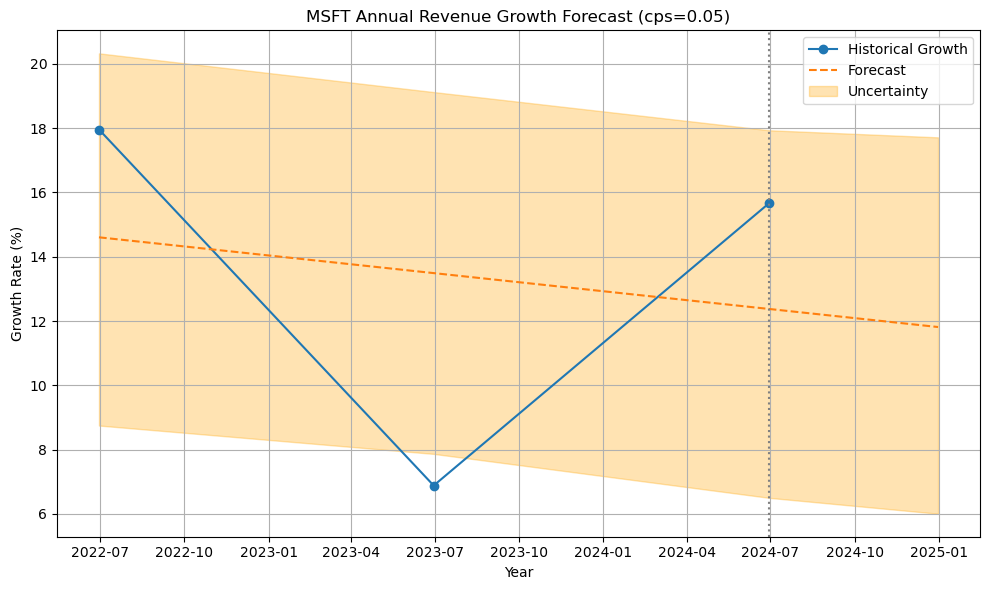

Best cps: 0.05
Next year growth: 11.81%


In [308]:
result = forecast_revenue_growth_rate_tuned("MSFT", history_years=10)
print("Best cps:", result["best_cps"])
print(f"Next year growth: {result['growth_rate']:.2f}%")

## Value Drivers (Operating Margin)

In [321]:
def forecast_operating_margin_tuned(
    symbol: str,
    history_years: int = 10,
    cps_grid=None
) -> dict:
    """
    Forecasts next year's operating margin (%) using Prophet,
    tuning changepoint_prior_scale via time-series CV on annual data.

    Returns:
      {
        best_cps: float,
        cv_results: DataFrame,
        margin_forecast: float,    # next-year operating margin (%)
        lower_bound: float,
        upper_bound: float,
        forecast_df: DataFrame     # ds, yhat, yhat_lower, yhat_upper
      }
    """
    # default grid
    if cps_grid is None:
        cps_grid = [0.01, 0.05, 0.1, 0.3, 0.5]

    # 1) Pull annual statements via yahooquery
    t = Ticker(symbol)
    inc = t.income_statement(frequency='a')
    if inc is None or inc.empty:
        raise ValueError(f"No annual income data for {symbol}")
    inc = inc.reset_index()
    inc12 = inc[inc['periodType']=='12M'].copy()
    inc12['asOfDate'] = pd.to_datetime(inc12['asOfDate'])
    inc12 = inc12.set_index('asOfDate').sort_index()

    # 2) Build operating margin series
    if not {'OperatingIncome','TotalRevenue'}.issubset(inc12.columns):
        raise ValueError("Required fields OperatingIncome or TotalRevenue missing")
    margin = (inc12['OperatingIncome'] / inc12['TotalRevenue']) * 100
    margin = margin.last(f"{history_years}Y").dropna()

    # 3) Prepare for Prophet
    df = margin.reset_index(name='y').rename(columns={'asOfDate':'ds'})[['ds','y']]

    # 4) Determine if tuning is feasible
    cv_results = pd.DataFrame()
    total_days = (df['ds'].max() - df['ds'].min()).days
    horizon_days = 365
    if total_days >= 2 * horizon_days:
        # compute initial window to leave horizon_days for testing
        initial_days = total_days - horizon_days
        tuning = []
        for cps in cps_grid:
            m = Prophet(
                yearly_seasonality=False,
                changepoint_prior_scale=cps,
                n_changepoints=min(5, len(df)-1)
            )
            m.fit(df)
            df_cv = cross_validation(
                m,
                initial=f"{initial_days} days",
                period="365 days",
                horizon="365 days",
                parallel="processes"
            )
            perf = performance_metrics(df_cv)
            tuning.append({
                'cps': cps,
                'mae': perf['mae'].mean(),
                'mape': perf['mape'].mean(),
                'rmse': perf['rmse'].mean()
            })
        cv_results = pd.DataFrame(tuning)
        best_cps = cv_results.loc[cv_results['mape'].idxmin(), 'cps']
    else:
        best_cps = 0.05

    # 5) Fit final model
    model = Prophet(
        yearly_seasonality=False,
        changepoint_prior_scale=best_cps,
        n_changepoints=min(5, len(df)-1)
    )
    model.fit(df)

    # 6) Forecast next year
    future = model.make_future_dataframe(periods=1, freq='A')
    forecast = model.predict(future)
    last = forecast.iloc[-1]
    margin_forecast = last['yhat']
    lower, upper = last['yhat_lower'], last['yhat_upper']

    # 7) Visualization
    plt.figure(figsize=(10,6))
    plt.plot(df['ds'], df['y'], 'o-', label='Historical Margin')
    plt.plot(forecast['ds'], forecast['yhat'], '--', label='Forecast')
    plt.fill_between(
        forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
        color='orange', alpha=0.3, label='Uncertainty'
    )
    plt.axvline(df['ds'].iloc[-1], color='gray', linestyle=':')
    plt.title(f"{symbol} Operating Margin Forecast (cps={best_cps})")
    plt.xlabel("Year")
    plt.ylabel("Operating Margin (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'best_cps': best_cps,
        'cv_results': cv_results,
        'margin_forecast': margin_forecast,
        'lower_bound': lower,
        'upper_bound': upper,
        'forecast_df': forecast[['ds','yhat','yhat_lower','yhat_upper']]
    }


2025-04-25 22:22:22,242 - prophet - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2025-04-25 22:22:22,243 - prophet - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2025-04-25 22:22:22,250 - prophet - INFO - n_changepoints greater than number of observations. Using 2.
2025-04-25 22:22:22,253 - cmdstanpy - DEBUG - input tempfile: /var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/tmpuy9jk7vk/165teefo.json
2025-04-25 22:22:22,254 - cmdstanpy - DEBUG - input tempfile: /var/folders/zc/mk397vzd3rndczvtnq2xwwzr0000gn/T/tmpuy9jk7vk/pxntg74u.json
2025-04-25 22:22:22,255 - cmdstanpy - DEBUG - idx 0
2025-04-25 22:22:22,255 - cmdstanpy - DEBUG - running CmdStan, num_threads: None
2025-04-25 22:22:22,256 - cmdstanpy - DEBUG - CmdStan args: ['/Users/tylerni/anaconda3/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66205', 'data', 'file=/var/folders/zc/mk397vzd3rndczvtnq

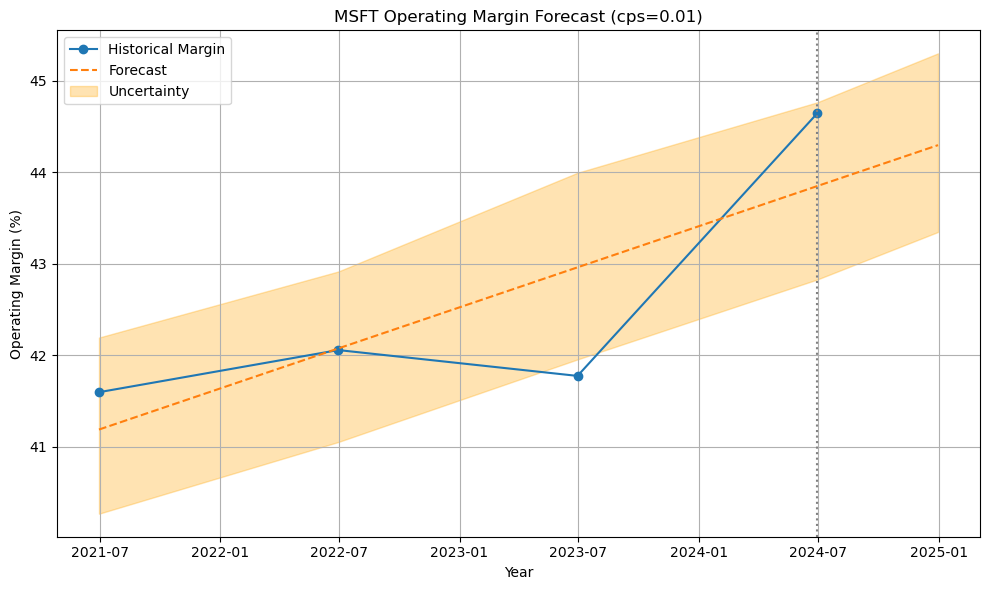

Next-year operating margin: 44.29%  (± 43.35%→45.30%)


In [323]:
res = forecast_operating_margin_tuned("MSFT", history_years=10)
print(f"Next-year operating margin: {res['margin_forecast']:.2f}%  (± {res['lower_bound']:.2f}%→{res['upper_bound']:.2f}%)")

In [ ]:
rev_growth_rate_for_next_year = input('What is the revenue growth rate for the next year?')
operating_margin_for_next_year = input('What is the operating margin for the next year?')
compounded_annual_growth_rate = input('What is the compounded annual growth rate?')
target_pre_tax_operating_margin = input('What is the target pre-tax operating margin?')
years_of_convergence_for_margin = input('How many years of convergence for the margin?')
sales_to_capital_ratio_for_years_1_to_5 = input('What is the sales to capital ratio for the first 5 years?')
sales_to_capital_ratio_for_years_6_to_10 = input('What is the sales to capital ratio for the last 5 years?')
input_worksheet.update('B26', [[rev_growth_rate_for_next_year]])
input_worksheet.update('B27', [[operating_margin_for_next_year]])
input_worksheet.update('B28', [[compounded_annual_growth_rate]])
input_worksheet.update('B29', [[target_pre_tax_operating_margin]])
input_worksheet.update('B30', [[years_of_convergence_for_margin]])
input_worksheet.update('B31', [[sales_to_capital_ratio_for_years_1_to_5]])
input_worksheet.update('B32', [[sales_to_capital_ratio_for_years_6_to_10]])

## Market Numbers

In [ ]:
rf = input('What is the riskfree rate?')
input_worksheet.update('B33', [[rf]])

## Other Inputs

In [ ]:
employee_options_outstanding = input('Do you have employee options outstanding?')
number_of_options_outstanding = input('What is the number of options outstanding?')
average_strike_price = input('What is the average strike price?')
average_maturity = input('What is the average maturity?')
standard_deviation_on_stock_price = input('What is the standard deviation on the stock price?')
input_worksheet.update('B37', [[employee_options_outstanding]])
input_worksheet.update('B38', [[number_of_options_outstanding]])
input_worksheet.update('B39', [[average_strike_price]])
input_worksheet.update('B40', [[average_maturity]])
input_worksheet.update('B41', [[standard_deviation_on_stock_price]])

In [ ]:
valuation_worksheet.acell('B33').value